In [1]:
# Import packages
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from numbers import Number
from tempfile import mkdtemp
from sklearn.pipeline import Pipeline

# Define settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
random_seed= 1618

## Data Preperation

In [2]:
# Create column names according to data source: "A1" - "A16"
col_names = ["A"+ str(i+1) for i in range(16)]

# Load dataset
data = pd.read_csv('data/crx.data', header=None, names=col_names)

# Inspect the first 10 rows
print(data.head(5))

  A1     A2     A3 A4 A5 A6 A7    A8 A9 A10  A11 A12 A13    A14  A15 A16
0  b  30.83  0.000  u  g  w  v  1.25  t   t    1   f   g  00202    0   +
1  a  58.67  4.460  u  g  q  h  3.04  t   t    6   f   g  00043  560   +
2  a  24.50  0.500  u  g  q  h  1.50  t   f    0   f   g  00280  824   +
3  b  27.83  1.540  u  g  w  v  3.75  t   t    5   t   g  00100    3   +
4  b  20.17  5.625  u  g  w  v  1.71  t   f    0   f   s  00120    0   +


In [3]:
# Inspect data
print(data.describe())
print(data.info())

               A3          A8        A11            A15
count  690.000000  690.000000  690.00000     690.000000
mean     4.758725    2.223406    2.40000    1017.385507
std      4.978163    3.346513    4.86294    5210.102598
min      0.000000    0.000000    0.00000       0.000000
25%      1.000000    0.165000    0.00000       0.000000
50%      2.750000    1.000000    0.00000       5.000000
75%      7.207500    2.625000    3.00000     395.500000
max     28.000000   28.500000   67.00000  100000.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    object 
 1   A2      690 non-null    object 
 2   A3      690 non-null    float64
 3   A4      690 non-null    object 
 4   A5      690 non-null    object 
 5   A6      690 non-null    object 
 6   A7      690 non-null    object 
 7   A8      690 non-null    float64
 8   A9      690 non-

In [4]:
# Change dependent varible labels to 1, 0
data['A16'] = [1 if v == '+' else 0 for v in data['A16']]

# Check dependent variable
balance = data['A16'].value_counts().rename({0:'reject',1:'accept'})
print(balance)

# Notice A14 is zip code if you look at the values 
# Drop zip code 
data = data.drop(columns='A14')

reject    383
accept    307
Name: A16, dtype: int64


In [5]:
# Print number of "?"
print(f"# of '?'s: {(data == '?').sum().sum()}")

# Replace '?' with nan
data = data.replace('?', np.nan)

# Print number of entries containing missing values 
print(f"# of entries with nan: {data.isna().any(axis=1).sum()}")

# Drop nan since columns are anonymous 
data = data.dropna()

# of '?'s: 54
# of entries with nan: 31


In [6]:
# Convert column A1 into float type
data['A2'] = data['A2'].astype('float')

# Fix cat column 
cat_cols = data.select_dtypes(exclude=np.number).columns.to_list()
for col in cat_cols:
    data[col] = data[col].astype('category')

X = data.drop(columns='A16')
y = data['A16']

# Split into train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)
num_cols = X.select_dtypes(include=np.number).columns.to_list()

## Model Training

In [7]:
# Define a helper function 
def estimator_name(estimator, local_items=locals().items()):
    '''Get the variable name of an estimator by searching throught all local items. A helper function
    Parameters
    ----------
    estimator: An estimator, i.e., LinearRegression()
    string_2_unmatch: 
    local_items: A dictornary of all variabel items produced by local.items() in the local scale
                where the estimators are
    '''
    for p, q in local_items:
        # If match the estimator 
        if ((p !='estimator') and (q is estimator)):
            return p

In [8]:
# One hot encoding and min max scaling
ohe_and_mmc = ColumnTransformer([('ohe',  OneHotEncoder(handle_unknown='ignore'), cat_cols),('mms', MinMaxScaler(), num_cols)]) 

# Use ROC AUC score as performamce measurement
scorers = ['roc_auc']

# Instanciate RepeatedStratifiedKFold
n_repeats = 50
n_splits = 10
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_seed)

# Intanciate estimators
logreg = LogisticRegression(random_state=random_seed)
dt = DecisionTreeClassifier(max_depth=6, random_state=random_seed)
rf = RandomForestClassifier(random_state=random_seed)
gbc = GradientBoostingClassifier(random_state=random_seed)

estimators = [logreg, dt, rf, gbc]
estimator_names=[]
cv_results = {}
fit_all_X_train_results = {}
local_items = locals().items()

# Train models and store results 
for estimator in estimators:
    # automate the naming process required by the Pipeline object
    e_name = estimator_name(estimator, local_items)
    estimator_names.append(e_name)
    steps = [('ohe_and_mmc',ohe_and_mmc), (e_name, estimator)]
    cachedir = mkdtemp()
    pipe = Pipeline(steps, memory=cachedir)
    cv_res = cross_validate(pipe, X_train, y_train, cv=rskf, return_train_score=True, return_estimator=True, scoring=scorers, error_score='raise', n_jobs=-1)   
    cv_results[e_name] = cv_res

    # Time the fitting process
    start = time.perf_counter()
    model_all_Xtrian = pipe.fit(X_train, y_train)
    end = time.perf_counter()
    time_fit_all_X_train = end - start

    # Use fit_all_X_train_results to store all the results for models fitted with all train data
    fit_all_X_train_results[e_name] = {'model': model_all_Xtrian}
    fit_all_X_train_results[e_name]['fit_time'] = time_fit_all_X_train  
    y_pred_proba = model_all_Xtrian.predict_proba(X_test)[:,1]
    fit_all_X_train_results[e_name]['y_pred_proba'] = y_pred_proba
    fit_all_X_train_results[e_name]['test_roc_auc'] = roc_auc_score(y_test, y_pred_proba)



## Model Selection
### 1. Cross Validation Scores

In [9]:
# Create dicts for storing cross validation medians and means
cv_medians = {}
cv_means = {}

for k, v in cv_results.items():
    # Create a dicitonary for each estimator to store metrics
    cv_medians[k] = {}
    cv_means[k] = {}
    for e_name, metric in v.items():
        if e_name != 'estimator': 
            cv_medians[k][e_name]= np.median(metric)  
            cv_means[k][e_name] = np.mean(metric)

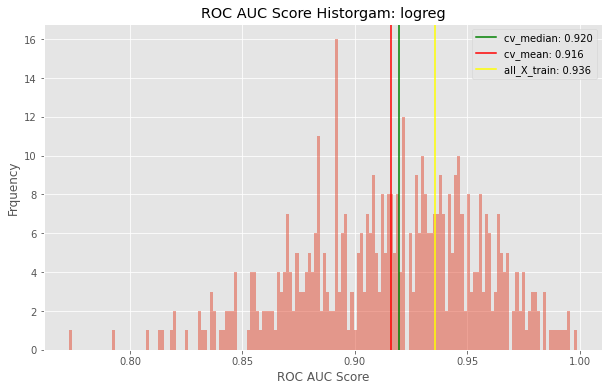

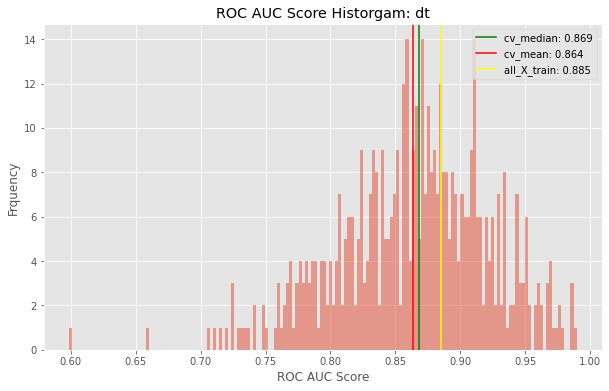

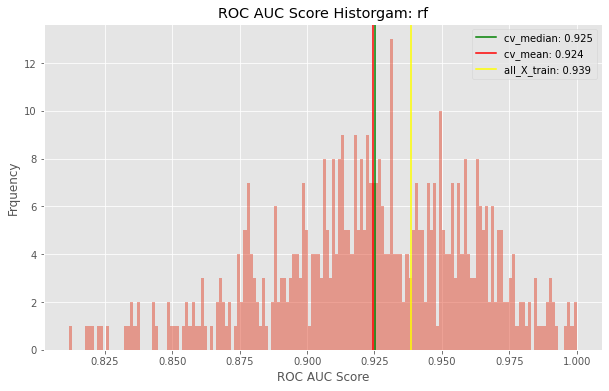

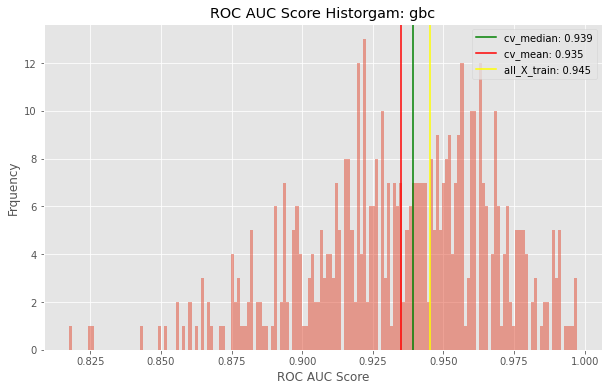

In [10]:
# Histplot for scores
for e_name in estimator_names:
    plt.figure(figsize=(10,6))
    plt.hist(cv_results[e_name]['test_roc_auc'], bins=int(n_repeats*n_splits/3), alpha=0.5)
    median = cv_medians[e_name]['test_roc_auc']
    mean = cv_means[e_name]['test_roc_auc']
    all_X_train = fit_all_X_train_results[e_name]['test_roc_auc']
    plt.axvline(median, color='green', 
                label=f"cv_median: {median:.3f}")
    plt.axvline(mean, color='red', 
                label=f"cv_mean: {mean:.3f}")
    plt.axvline(all_X_train, color='yellow', 
                label=f"all_X_train: {all_X_train:.3f}")
    plt.title('ROC AUC Score Historgam: '+ e_name)
    plt.ylabel('Frquency')
    plt.xlabel('ROC AUC Score')
    plt.legend(loc='upper right')
    filename = 'figures/histogram_'+e_name+'_.png'
    plt.savefig(filename, facecolor='white')
    plt.show();

In [11]:
# Define a wrapper function
def position_tuples_from_boxplot(ax, showmeans=True):
    '''Return a list of tuples of positions, like [(x, y_median, y_mean), ...] '''
    res = []
    if showmeans == True:
        lines = ax.get_lines()
        x_pos = ax.get_xticks()
        for x in x_pos:
            # every 4th line at the interval of 6 is the median line when showmeans = False;
            # when showmeans = True, mean is the every 5th line at the interval of 7,
            # (0 = 25th percentile, 1 = 75th percentile, 2 = lower whisker, 
            # 3 = upper whisker, 4 = 50th percentile (median), and 5 = mean, 6 = upper extreme value) 
            y_median = lines[4 + x*7].get_ydata()[0]
            y_mean = lines[5 + x*7].get_ydata()[0]
            res.append((x, y_median, y_mean))
        return res


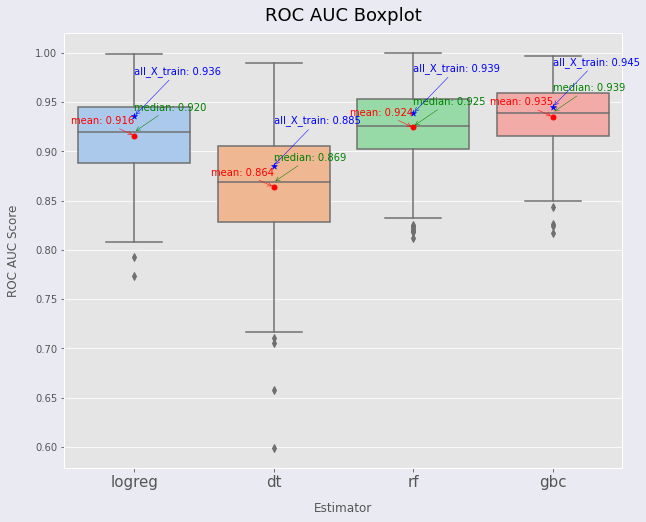

In [12]:
score_df = pd.DataFrame()
for e_name in estimator_names:
    score_df[e_name] = cv_results[e_name]['test_roc_auc']

# Boxplot for scores
facecolor = '#eaeaf2'
fig_size = (10,8)
h_padding = int(fig_size[0]*1.5)
v_padding = int(fig_size[1]*1.5)
title_size = int(fig_size[0]*1.8)
xlabel_size = int(fig_size[1]*1.6)
ylabel_size = int(fig_size[1]*1.6)

fig, ax = plt.subplots(figsize=fig_size,facecolor=facecolor)
bp = sns.boxplot(data=score_df,
            showmeans=True,
            meanprops={"marker": ".",
                    "markeredgecolor": "red",
                    "markerfacecolor": "red",
                    "markersize": "10"},
            ax=ax, 
            palette='pastel')
ax.tick_params(axis='x', labelsize=h_padding)

# Plot a marker of the time for fitting all X train using a scatter plot
pos = list(zip(*position_tuples_from_boxplot(bp)))
x_pos_all_X_train = pos[0]
y_pos_all_X_train = [v['test_roc_auc'] for _, v in fit_all_X_train_results.items()]
plt.scatter(x_pos_all_X_train, y_pos_all_X_train, marker='*', color='blue', s=40)

pos.append(tuple(y_pos_all_X_train))
for x, ymedian, ymean, yalltrain in zip(*pos):
    plt.annotate(text=f"median: {ymedian:.3f}", xy=(x, ymedian), xytext=(x, ymedian+0.02), color='green', 
                 ha = 'left', va = 'bottom', 
                 arrowprops=dict(color='green', arrowstyle='->'),)
    plt.annotate(text=f"mean: {ymean:.3f}", xy=(x, ymean), xytext=(x, ymean+0.02), color='red', 
                 ha = 'right', va = 'top', 
                 arrowprops=dict(color='red', arrowstyle='->'),)
    plt.annotate(text=f"all_X_train: {yalltrain:.3f}", xy=(x, yalltrain), xytext=(x, yalltrain+0.04), color='blue', 
                 ha = 'left', va = 'bottom', 
                 arrowprops=dict(color='blue', arrowstyle='->'),)

plt.ylabel('ROC AUC Score', fontsize=ylabel_size, labelpad=h_padding)
plt.xlabel('Estimator', fontsize=xlabel_size, labelpad=v_padding)
plt.title('ROC AUC Boxplot', fontsize=title_size, pad=v_padding)
plt.savefig('figures/boxplot_auc.png')
plt.show();



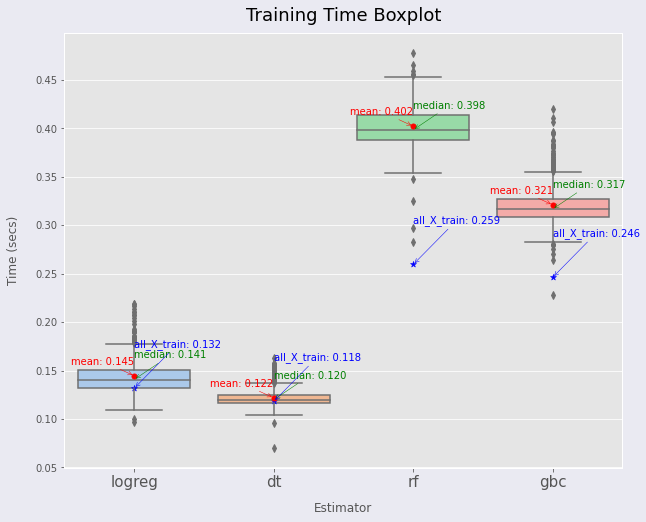

In [13]:
time_df = pd.DataFrame()
for e_name in estimator_names:
    time_df[e_name] = cv_results[e_name]['fit_time']
# Score time is available with cv_results[name]['score_time'] 

# Boxplot for fit time
fig_size = (10,8)
h_padding = int(fig_size[0]*1.5)
v_padding = int(fig_size[1]*1.5)
title_size = int(fig_size[0]*1.8)
xlabel_size = int(fig_size[1]*1.6)
ylabel_size = int(fig_size[1]*1.6)

fig, ax = plt.subplots(figsize=fig_size,facecolor=facecolor)
bp = sns.boxplot(data=time_df,
            showmeans=True,
            meanprops={"marker": ".",
                    "markeredgecolor": "red",
                    "markerfacecolor": "red",
                    "markersize": "10"},
            ax=ax, 
            palette='pastel')
ax.tick_params(axis='x', labelsize=int(fig_size[0]*1.5))

# Plot a marker of the time for fitting all X train using a scatter plot
pos = list(zip(*position_tuples_from_boxplot(bp)))
x_pos_all_X_train = pos[0]
y_pos_all_X_train = [v['fit_time'] for _, v in fit_all_X_train_results.items()]
plt.scatter(x_pos_all_X_train, y_pos_all_X_train, marker='*', color='blue', s=40)

pos.append(tuple(y_pos_all_X_train))
for x, ymedian, ymean, yalltrain in zip(*pos):
    plt.annotate(text=f"median: {ymedian:.3f}", xy=(x, ymedian), xytext=(x, ymedian+0.02), color='green', 
                 ha = 'left', va = 'bottom', 
                 arrowprops=dict(color='green', arrowstyle='->'),)
    plt.annotate(text=f"mean: {ymean:.3f}", xy=(x, ymean), xytext=(x, ymean+0.02), color='red', 
                 ha = 'right', va = 'top', 
                 arrowprops=dict(color='red', arrowstyle='->'),)
    plt.annotate(text=f"all_X_train: {yalltrain:.3f}", xy=(x, yalltrain), xytext=(x, yalltrain+0.04), color='blue', 
                 ha = 'left', va = 'bottom', 
                 arrowprops=dict(color='blue', arrowstyle='->'),)

plt.ylabel('Time (secs)', fontsize=ylabel_size, labelpad=h_padding)
plt.xlabel('Estimator', fontsize=xlabel_size, labelpad=v_padding)
plt.title('Training Time Boxplot', fontsize=title_size, pad=v_padding) 
plt.savefig('figures/boxplot_time.png')
plt.show();


## Model Selection
### 2. Test Scores

In [14]:
# Define a wrapper function to plot roc auc curve
def plot_roc_auc(y_true, y_pred_proba, fig_size=(8,8), title_string=f'ROC AUC Curve', save_as=None):
    '''Plot ROC AUC curve'''
    facecolor = 'white'
    fig_size = (10,8)
    h_padding = int(fig_size[0]*1.5)
    v_padding = int(fig_size[1]*1.5)
    title_size = int(fig_size[0]*1.8)
    xlabel_size = int(fig_size[1]*1.6)
    ylabel_size = int(fig_size[1]*1.6)
    
    # get fpr, tpr and threshold
    auc = roc_auc_score(y_true, y_pred_proba)
    fpr, tpr, threshold = roc_curve(y_true, y_pred_proba)

    fig, ax = plt.subplots(figsize=fig_size, facecolor=facecolor)
    # ROC line
    plt.plot(fpr,tpr, label='ROC')
    # AUC area
    plt.fill_between(fpr, tpr, color='khaki', alpha=0.5, label=f'AUC: {auc:.3f}')

    plt.legend(loc='upper left', fontsize='large', bbox_to_anchor=(1, 1))
    plt.xlabel('False Positive Rate \n (Type 1 Error)', size=xlabel_size, labelpad=h_padding)
    # 'True Positive Rate = 1 - Type 2 Error Rate (a.k.a., Sensitivity or Recall or Power)'
    plt.ylabel('True Positive Rate \n (1 - Type 2 Error)',size=ylabel_size, labelpad=h_padding)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title(title_string, size=title_size, pad=v_padding)
    ax.set_aspect('equal')
    if save_as:
        plt.savefig(save_as, bbox_inches='tight')
    plt.show();


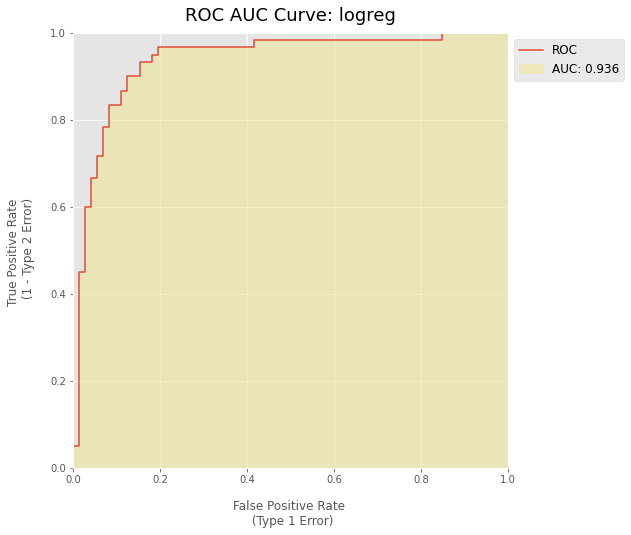

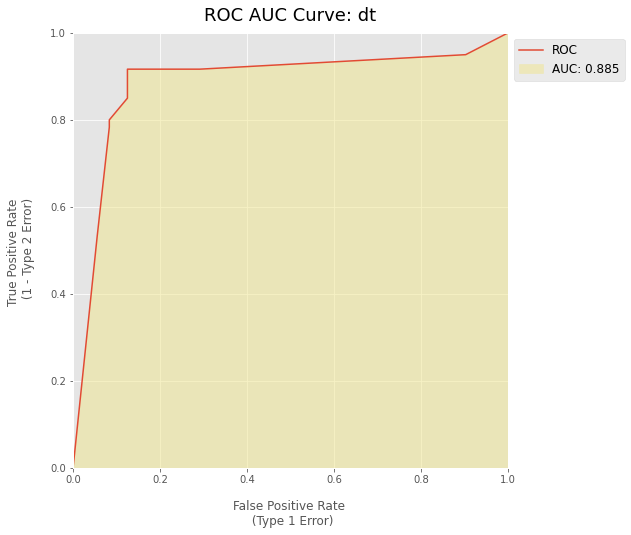

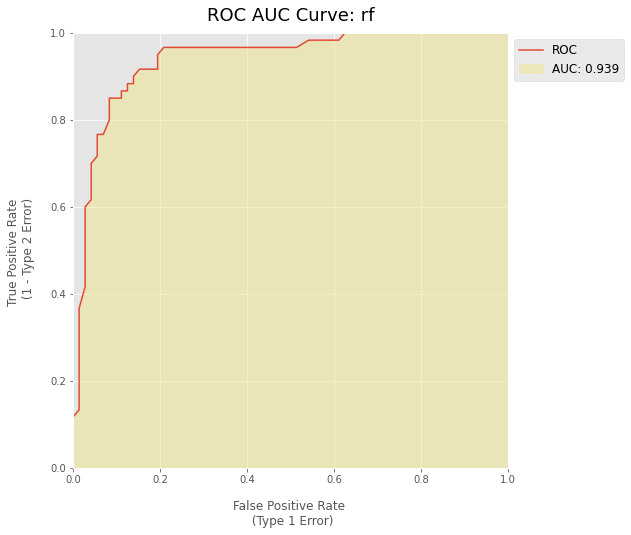

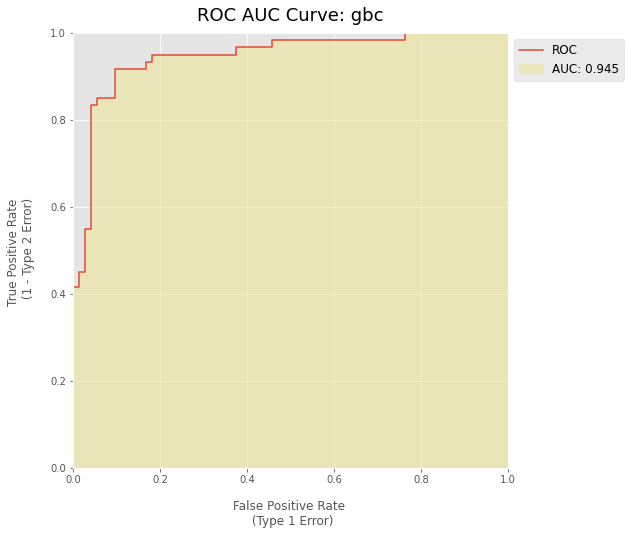

In [15]:
# Plot roc auc for models fitted with all training data
for e_name in estimator_names:
    plot_roc_auc(y_test, fit_all_X_train_results[e_name]['y_pred_proba'], 
                title_string=f'ROC AUC Curve: '+ e_name,
                save_as='figures/roc_auc_curve_' + e_name + '.png')


In [16]:
# Define a wrapper func to plot importances
def plot_feature_importance(importance: pd.Series, top_n = 20, title = f"Feature Importance / Coefficients", 
                            fig_size=(12,8),
                            save_as = f"figures/importance_plot.png"):
    h_padding = int(fig_size[0]*1.5)
    v_padding = int(fig_size[1]*1.5)
    title_size = int(fig_size[0]*1.8)
    xlabel_size = int(fig_size[1]*1.6)
    ylabel_size = int(fig_size[1]*1.6)
    if top_n > importance.shape[0]:
        top_n = importance.shape[0]
    importance = importance.iloc[:top_n]
    x = [2*i for i in range(top_n)]
    x_py = [i+0.3 for i in x]
    fig, ax = plt.subplots(figsize=fig_size, facecolor='white')
    plt.bar(x, importance.values)
    plt.title(title, pad=v_padding)
    plt.xticks(x, importance.index,rotation=60, ha='right')
    for tk in plt.gca().get_xticklabels()[:5]:
        tk.set_color('red')
        tk.set_fontsize(15)
    plt.xlabel(f"Feature, Top {top_n}", size=xlabel_size, labelpad=v_padding)
    plt.ylabel(f"Impotance / Coefficient", size=ylabel_size, labelpad=h_padding)
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as)
    plt.show();

## Interpretation (sort of)

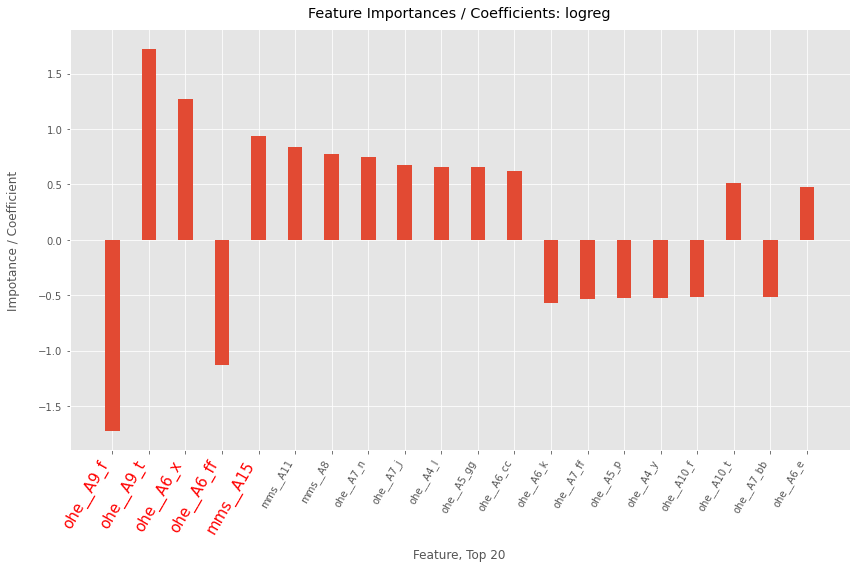

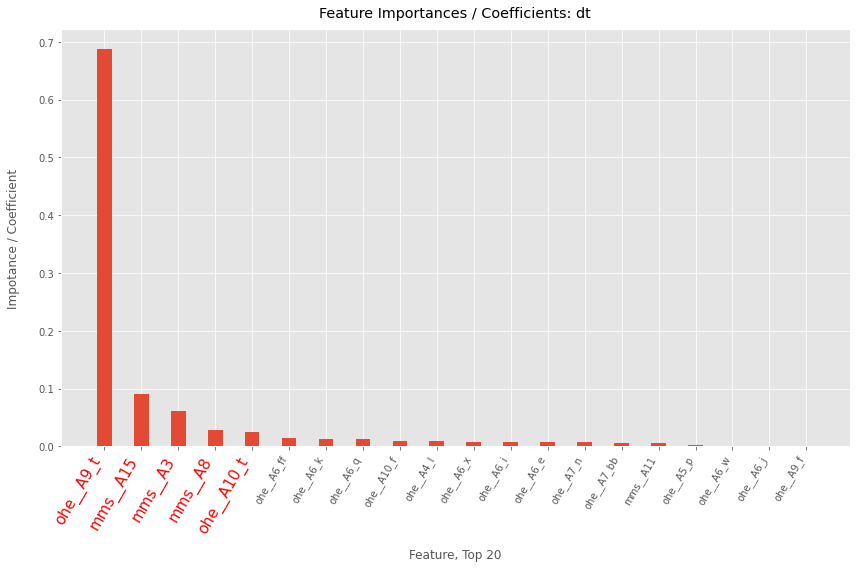

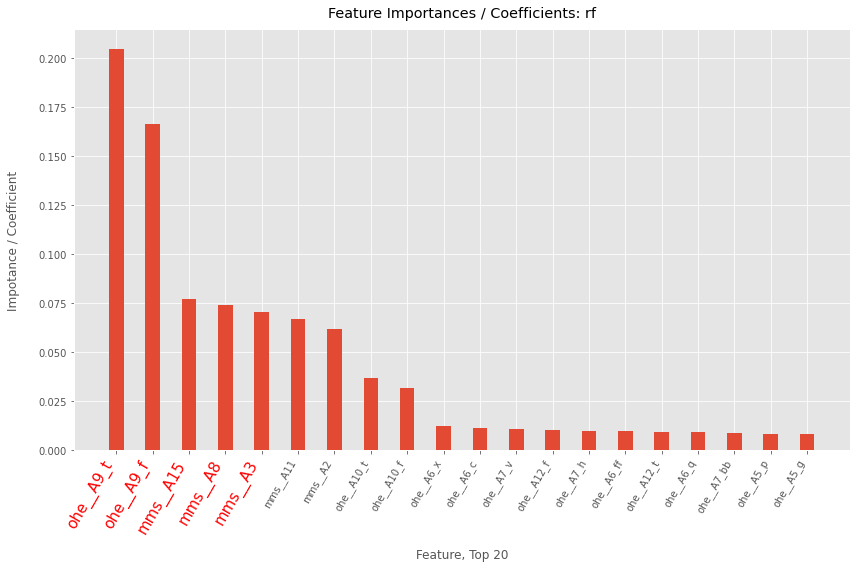

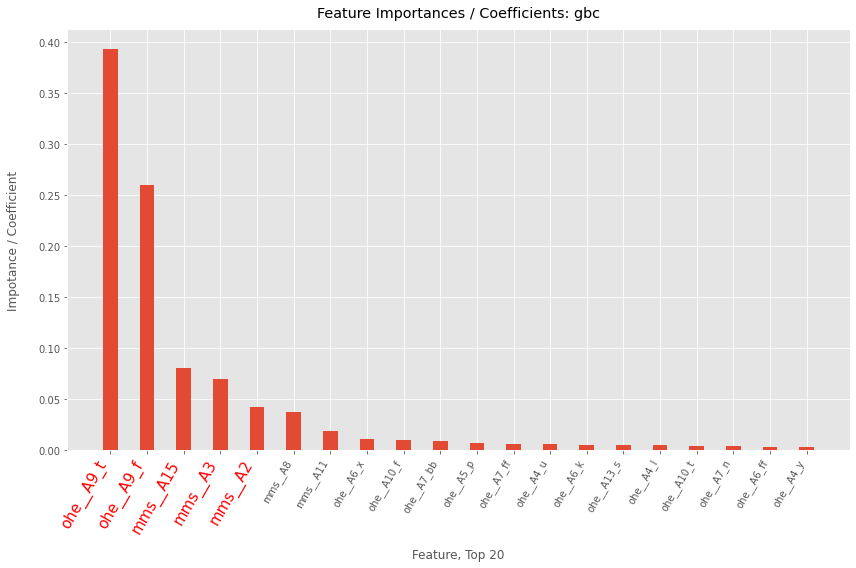

In [17]:
# Iterate over estimator names and plot feature importance
for e_name in estimator_names:
    columns_bm = fit_all_X_train_results[e_name]['model'].named_steps['ohe_and_mmc'].get_feature_names_out()
    try:
        importance = fit_all_X_train_results[e_name]['model'].named_steps[e_name].coef_[0]
    except:
        importance = fit_all_X_train_results[e_name]['model'].named_steps[e_name].feature_importances_
    importance = pd.Series(importance,index=columns_bm).sort_values(ascending=False, key=abs)

    # plot importance 
    plot_feature_importance(importance, title=f"Feature Importances / Coefficients: {e_name}", 
                            save_as=f"figures/importance_plot_{e_name}.png")

## Conclusion

In [ ]:
# Conclusion
comment = f"Pick the model with the best cross validation performances, \
since the training time doesn't vary significantly across all models. "
best_model = 'gbc'
most_importance_feature = f"A9"
print(comment)
print(f"The best model: {fit_all_X_train_results[best_model]['model'][best_model]}.")
print(f"The most important feature: {most_importance_feature}.")

Pick the model with the best cross validation performances, since the training time doesn't vary significantly across all models. 
The best model: GradientBoostingClassifier(random_state=1618).
The most important feature: A9.
